<p style="color:#737373; font-family:futura; font-size:200%;">Partial Differential Equations</p>
<p style="color:#737373; font-family:futura;">9 February 2021</p>

<center style="font-family:futura; font-size:150%;">Upwind Differencing</center>

<img src="diagram.png" style="float: center;" width=500 height=500/>

Divide the length of the heat exchanger into $n$ parts where the enthalpy is $H_j$ in the $j^{th}$ unit. 

Let's assume (for now) that $\rho$ is not a strong function of temperature. 

Hot side (backward difference):

$A_c \Delta z \rho_H H_H^{(j)} |_{t + \Delta t} - A_c \Delta z \rho_H H_H^{(j)} |_{t} = m_H H_H^{(j-1)}\Delta t - m_H H_H^{(j)}\Delta t - UP \Delta z (T_H^{(j)} - T_C^{(j)})\Delta t$

$$\implies \frac{dH_H^{(j)}}{dt} = \frac{m_H}{A_c \rho_H \Delta z} H_H^{(j-1)} - \frac{m_H}{A_c \rho_H \Delta z} H_H^{(j)} - \frac{UP}{A_c \rho_H} (T_H^{(j)} - T_C^{(j)})$$

---

Cold side (forward difference):

$A_c \Delta z \rho_C H_C^{(j)} |_{t + \Delta t} - A_c \Delta z \rho_C H_C^{(j)} |_{t} = m_C H_C^{(j+1)}\Delta t - m_C H_C^{(j)}\Delta t + UP \Delta z (T_H^{(j)} - T_C^{(j)})\Delta t$

$$\implies \frac{dH_C^{(j)}}{dt} = \frac{m_C}{A_c \rho_C \Delta z} H_H^{(j+1)} - \frac{m_H}{A_c \rho_C \Delta z} H_H^{(j)} + \frac{UP}{A_c \rho_C}  (T_H^{(j)} - T_C^{(j)})$$

---
(where $\frac{m}{A_c \rho} = \text{velocity}$)


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.integrate
import scipy.interpolate
import scipy.optimize
from matplotlib import style
from matplotlib.animation import FuncAnimation
from crosscurrentHX import CrossCurrentHX
import seaborn as sns

from IPython.display import display, Math, Image
%config InlineBackend.figure_format = 'retina'

style.use("classic")

In [2]:
data = pd.read_csv("CpData.csv").replace(np.NaN, 0)
data.index += 1
comp = data['Name']
MW = data['Mol. wt.']
Tmin = data['Tmin, K']
Tmax = data['Tmax, K']
C1 = data['C1']
C2 = data['C2']
C3 = data['C3']
C4 = data['C4']
C5 = data['C5']

<center style="font-family:futura; font-size:150%;">Enthalpy-temperature function</center>

$$C_p = C_1 + C_2 T + C_3 T^2 + C_4 T^3 + C_5 T^4$$

$$H = \int_{T_{ref}}^{T}C_p dT = C_1 (T - T_{ref}) + C_2 \frac{T^2 - T^2_{ref}}{2} + C_3 \frac{T^3 - T^3_{ref}}{3} + + C_4 \frac{T^4 - T^4_{ref}}{4} + C_5 \frac{T^5 - T^5_{ref}}{5}$$

In [3]:
compH = 'Benzene'    # HOT fluid
compC = 'Ethylene glycol'    # COLD fluid

In [4]:
iH = comp.index[comp == compH].tolist()[0]
iC = comp.index[comp == compC].tolist()[0]

In [5]:
Tref = 293.15  # K

def H_H(T):  # T in K, H in J/kg
    return (C1[iH] * (T - Tref) + C2[iH] * (T ** 2 - Tref ** 2) / 2 +
            C3[iH] * (T ** 3 - Tref ** 3) / 3 + C4[iH] * (T ** 4 - Tref ** 4) / 4 +
            C5[iH] * (T ** 5 - Tref ** 5) / 5) / MW[iH]


def H_C(T):  # T in K, H in J/kg
    return (C1[iC] * (T - Tref) + C2[iC] * (T ** 2 - Tref ** 2) / 2 +
            C3[iC] * (T ** 3 - Tref ** 3) / 3 + C4[iC] * (T ** 4 - Tref ** 4) / 4 +
            C5[iC] * (T ** 5 - Tref ** 5) / 5) / MW[iC]

# Using linear interpolation to find temperature at a given enthalpy value

T = np.linspace(max(Tmin[iH], Tmin[iC]), min(Tmax[iH], Tmax[iC]), 500)
T_H = scipy.interpolate.UnivariateSpline(H_H(T), T, k=1, s=0)
T_C = scipy.interpolate.UnivariateSpline(H_C(T), T, k=1, s=0)

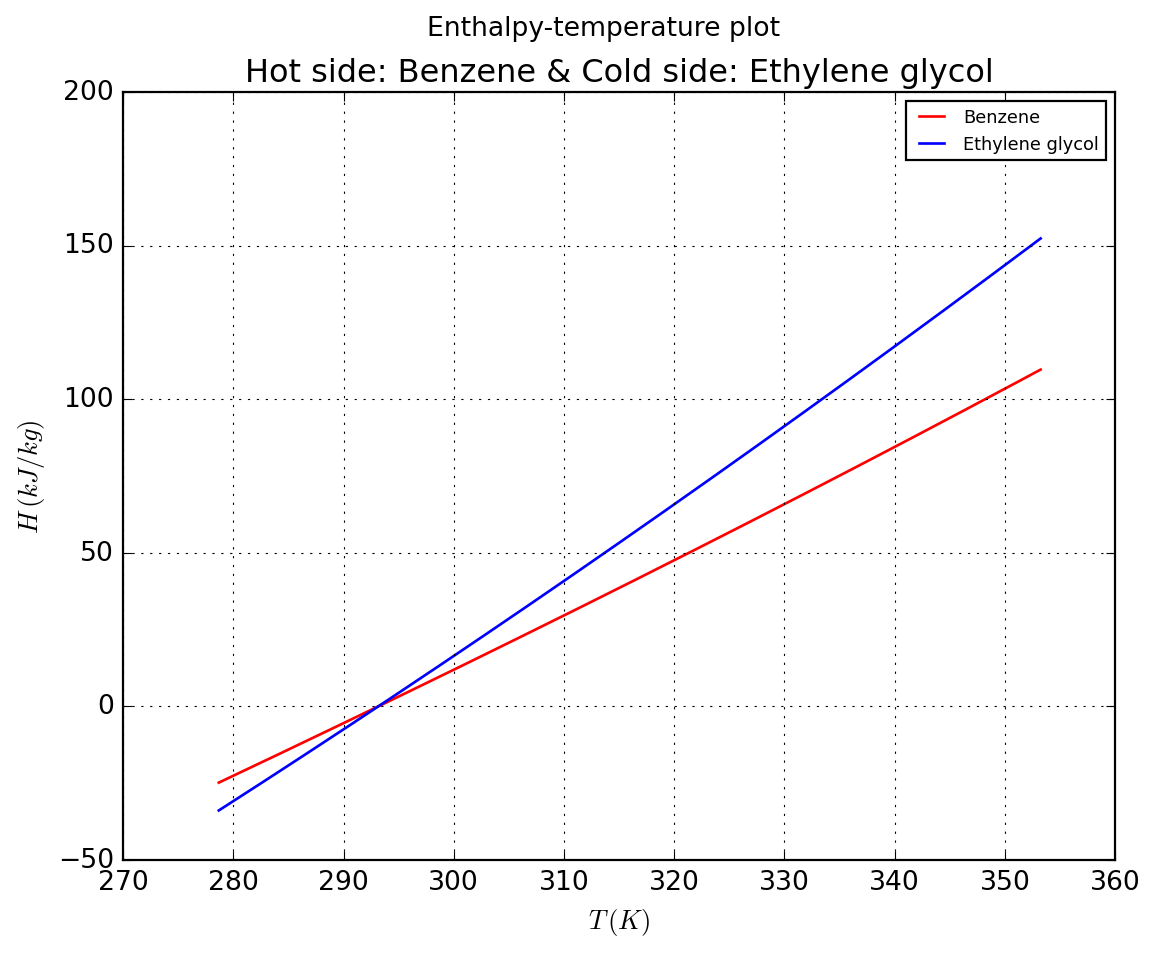

In [6]:
plt.figure(facecolor='white')
plt.grid()
plt.suptitle("Enthalpy-temperature plot")
plt.title("Hot side: %s & Cold side: %s" % (compH, compC))
plt.plot(T, H_H(T) * 1e-3, color='red', linewidth=1.2, label=compH)
plt.plot(T, H_C(T) * 1e-3, color='blue', linewidth=1.2, label=compC)
plt.xlabel(r'$T\, (K)$')
plt.ylabel(r'$H\, (kJ/kg)$')
plt.legend(loc='best', fontsize=8);

<center style="font-family:futura; font-size:150%;">Solving Partial Differential Equations</center>

In [7]:
class CounterCurrentHX:
    def __init__(self, n):
        self.U = 350.0  # W/m2-K
        self.P = np.pi * 0.1  # m2/m
        self.AcH = np.pi * 0.25 * 0.1 ** 2  # m2
        self.AcC = np.pi * 0.25 * 0.1 ** 2  # m2
        self.L = 1.0  # m
        
        self.rhoH = 876 # kg/m3
        self.rhoC = 1110 # kg/m3
        
        self.mH = 0.05  # kg/s
        self.mC = 0.10  # kg/s
        
        self.T_Hin = 323.16  # K
        self.T_Cin = 303.16  # K
        
        self.n = n # Number of grid points
                
        self.Tini = np.ones(self.n * 2) * self.T_Cin
#         Tini[:self.n] = Tini[:self.n] * self.T_Hin
#         Tini[self.n:] = Tini[self.n:] * self.T_Cin

    def model(self, H, t): 
        H_hot = H[:self.n]
        H_cold = H[self.n:]

        T_hot = T_H(H_hot)
        T_cold = T_C(H_cold)
        
        H_Hin = H_H(self.T_Hin)
        H_Cin = H_C(self.T_Cin)
        
        dz = self.L / self.n
        
        dH_hotdt = np.zeros(self.n)
        dH_colddt = np.zeros(self.n)
        
        dH_hotdt[1:] = self.mH / (self.AcH * self.rhoH * dz) * H_hot[0:-1] - self.mH / (self.AcH * self.rhoH * dz) * H_hot[1:] - self.U * self.P / (self.AcH * self.rhoH) * (T_hot[1:] - T_cold[1:]) 
        dH_colddt[:-1] = self.mC / (self.AcC * self.rhoC * dz) * H_cold[1:] - self.mC / (self.AcC * self.rhoC * dz) * H_cold[:-1] + self.U * self.P / (self.AcC * self.rhoC) * (T_hot[:-1] - T_cold[:-1]) 
        
        dH_hotdt[0] = self.mH / (self.AcH * self.rhoH * dz) * H_Hin - self.mH / (self.AcH * self.rhoH * dz) * H_hot[0] - self.U * self.P / (self.AcH * self.rhoH) * (T_hot[0] - T_cold[0]) 
        dH_colddt[-1] = self.mC / (self.AcC * self.rhoC * dz) * H_Cin - self.mC / (self.AcC * self.rhoC * dz) * H_cold[-1] + self.U * self.P / (self.AcC * self.rhoC) * (T_hot[-1] - T_cold[-1]) 

        return list(dH_hotdt) + list(dH_colddt)

    def solve(self, t):
        H0 = np.zeros(self.n * 2)
        H0[:self.n] = H_H(self.Tini[:self.n])
        H0[self.n:] = H_C(self.Tini[self.n:])
        
        sol = scipy.integrate.odeint(self.model, H0, t)
        
        dz = self.L / self.n
        pos = [(i + 0.5) * dz for i in range(self.n)] 

        self.t = t
        self.pos = pos
        self.sol = sol

In [8]:
def TYPEI_sol(n, period):
    t = np.linspace(0, period, n)
    hx = CounterCurrentHX(n)
    hx.solve(t)
    
    bvp = CrossCurrentHX()
    bvp.solve()
    
    fig = plt.figure(facecolor='white', figsize=(5, 5))
    plt.suptitle("Temperature vs Length of Heat Exchanger (n = %d)" % n)
    plt.grid()
    plt.xlim(0, hx.L)
    plt.ylim(0.97 * hx.T_Cin, 1.03 * hx.T_Hin)
    plt.xlabel(r"$z\, (m)$", fontsize=7)
    plt.ylabel(r"$T\, (K)$", fontsize=7)
    plt.plot(bvp.dfsol.z, bvp.dfsol.T_H, color='#ff9999', linewidth=1.2, linestyle='--')
    plt.plot(bvp.dfsol.z, bvp.dfsol.T_C, color='#80b3ff', linewidth=1.2, linestyle='--')
    plt.annotate(r'$T_H^{in}$', xy=(0, hx.T_Hin))
    plt.annotate(r'$T_C^{in}$', xy=(hx.L, hx.T_Cin))
    
    line1 = plt.plot([], 'r', label='Hot side - %s' % compH)[0]
    line2 = plt.plot([], 'b', label='Cold side - %s' % compC)[0]
    plt.legend(loc='best', fontsize=7)
    
    def animated_plot(i):  
        i = int(i)
        plt.title(r"$t = %d\, s$" % hx.t[i])
        line1.set_data((hx.pos, T_H(hx.sol[i][:hx.n]))) 
        line2.set_data((hx.pos, T_C(hx.sol[i][hx.n:]))) 
        return line1, line2
     
    animation = FuncAnimation(fig, animated_plot, frames=n, interval=200);
    animation.save('animation_%d_%d_I.gif' % (n, period), writer='ffmpeg')
    return Image(url='animation_%d_%d_I.gif' % (n, period))

def TYPEII_sol(n, period):
    t = np.linspace(0, period, n)
    hx = CounterCurrentHX(n)
    hx.Tini = np.ones(n * 2) * (hx.T_Hin + hx.T_Cin) / 2
    hx.solve(t)
    
    bvp = CrossCurrentHX()
    bvp.solve()
    
    fig = plt.figure(facecolor='white', figsize=(5, 5))
    plt.suptitle("Temperature vs Length of Heat Exchanger (n = %d)" % n)
    plt.grid()
    plt.xlim(0, hx.L)
    plt.ylim(0.97 * hx.T_Cin, 1.03 * hx.T_Hin)
    plt.xlabel(r"$z\, (m)$", fontsize=7)
    plt.ylabel(r"$T\, (K)$", fontsize=7)
    plt.plot(bvp.dfsol.z, bvp.dfsol.T_H, color='#ff9999', linewidth=1.2, linestyle='--')
    plt.plot(bvp.dfsol.z, bvp.dfsol.T_C, color='#80b3ff', linewidth=1.2, linestyle='--')
    plt.annotate(r'$T_H^{in}$', xy=(0, hx.T_Hin))
    plt.annotate(r'$T_C^{in}$', xy=(hx.L, hx.T_Cin))
    
    line1 = plt.plot([], 'r', label='Hot side - %s' % compH)[0]
    line2 = plt.plot([], 'b', label='Cold side - %s' % compC)[0]
    plt.legend(loc='best', fontsize=7)
    
    def animated_plot(i):  
        i = int(i)
        plt.title(r"$t = %d\, s$" % hx.t[i])
        line1.set_data((hx.pos, T_H(hx.sol[i][:hx.n]))) 
        line2.set_data((hx.pos, T_C(hx.sol[i][hx.n:]))) 
        return line1, line2
     
    animation = FuncAnimation(fig, animated_plot, frames=n, interval=200);
    animation.save('animation_%d_%d_II.gif' % (n, period), writer='ffmpeg')
    return Image(url='animation_%d_%d_II.gif' % (n, period))

def get_HeatMap_I(n, period):
    t = np.linspace(0, period, n)
    hx = CounterCurrentHX(n)
    hx.solve(t)

    fig = plt.figure(facecolor='white')
    plt.suptitle(r"Heat Map, $n = %d$" % (n))
    plt.xlim(0, hx.L)
#     xticklables = [round(x, 1) for x in hx.pos]

    data_0 = pd.DataFrame({r"$T_H$": T_H(hx.sol[0][:hx.n]),
                           r"$T_C$": T_C(hx.sol[0][hx.n:])}).transpose()
    ax = sns.heatmap(data_0, cmap='jet', xticklabels=False, vmin=hx.T_Cin, vmax=hx.T_Hin)

    def animated_heatmap(i):
        i = int(i)
        plt.clf()
        plt.xkcd()
        plt.title(r"$t = %d\, s$" % hx.t[i])
        data = pd.DataFrame({r"$T_H$": T_H(hx.sol[i][:hx.n]),
                             r"$T_C$": T_C(hx.sol[i][hx.n:])}).transpose()

        ax = sns.heatmap(data, cmap='jet', xticklabels=False, vmin=hx.T_Cin, vmax=hx.T_Hin)

    ani = matplotlib.animation.FuncAnimation(fig, animated_heatmap, frames=n, interval=200)
    ani.save('heat_map_%d_%d_I.gif' % (n, period), writer='ffmpeg')
    return Image(url='heat_map_%d_%d_I.gif' % (n, period))

def get_HeatMap_II(n, period):
    t = np.linspace(0, period, n)
    hx = CounterCurrentHX(n)
    hx.Tini = np.ones(n * 2) * (hx.T_Hin + hx.T_Cin) / 2
    hx.solve(t)

    fig = plt.figure(facecolor='white')
    plt.suptitle(r"Heat Map, $n = %d$" % (n))
    plt.xlim(0, hx.L)
#     xticklables = [round(x, 1) for x in hx.pos]

    data_0 = pd.DataFrame({r"$T_H$": T_H(hx.sol[0][:hx.n]),
                           r"$T_C$": T_C(hx.sol[0][hx.n:])}).transpose()
    ax = sns.heatmap(data_0, cmap='jet', xticklabels=False, vmin=hx.T_Cin, vmax=hx.T_Hin)

    def animated_heatmap(i):
        i = int(i)
        plt.clf()
        plt.xkcd()
        plt.title(r"$t = %d\, s$" % hx.t[i])
        data = pd.DataFrame({r"$T_H$": T_H(hx.sol[i][:hx.n]),
                             r"$T_C$": T_C(hx.sol[i][hx.n:])}).transpose()

        ax = sns.heatmap(data, cmap='jet', xticklabels=False, vmin=hx.T_Cin, vmax=hx.T_Hin)

    ani = matplotlib.animation.FuncAnimation(fig, animated_heatmap, frames=n, interval=200)
    ani.save('heat_map_%d_%d_II.gif' % (n, period), writer='ffmpeg')
    return Image(url='heat_map_%d_%d_II.gif' % (n, period))

<p style="font-family:futura;">Initialization TYPE I</p>

```python
Tini = np.ones(n * 2) * T_Cin
```

<p style="font-family:futura;">Initialization TYPE II</p>

```python
Tini = np.ones(n * 2) * (T_Hin + T_Cin)/2
```

<center style="font-family:futura; font-size:150%;">10 grids</center>

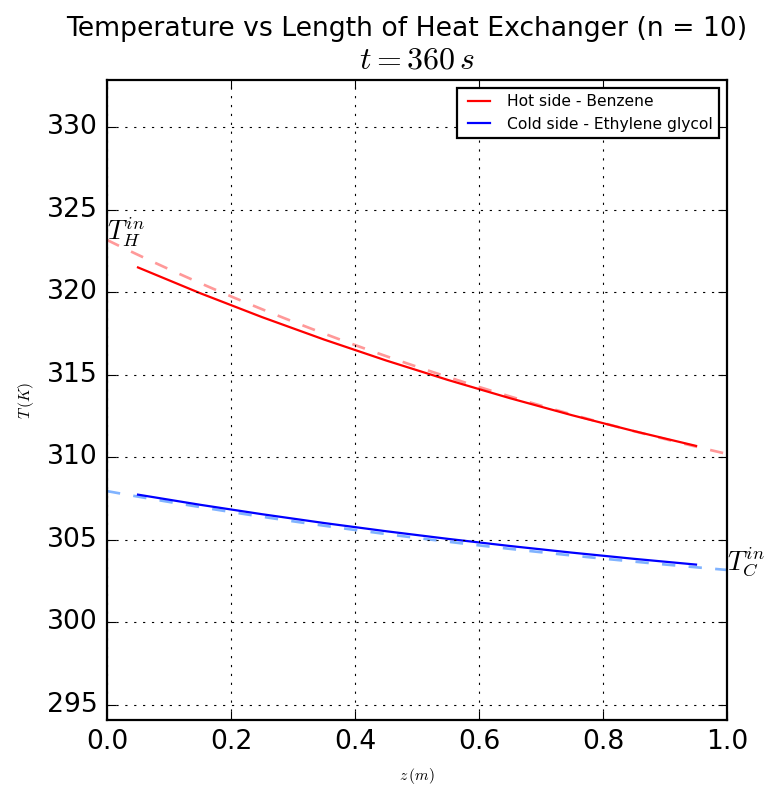

In [9]:
period1 = 360
TYPEI_sol(10, period1)

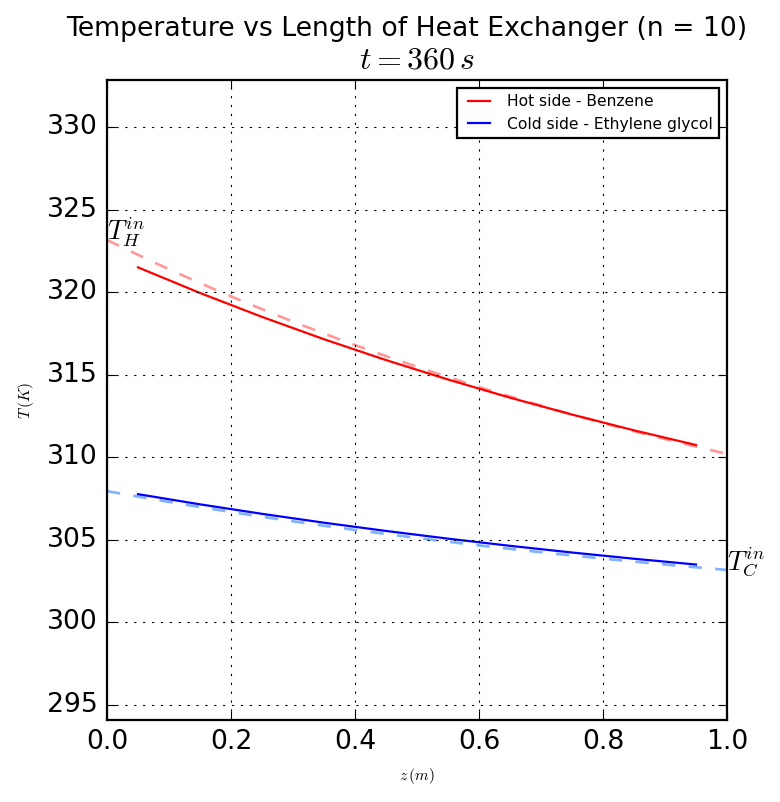

In [10]:
period2 = 360
TYPEII_sol(10, period2) 

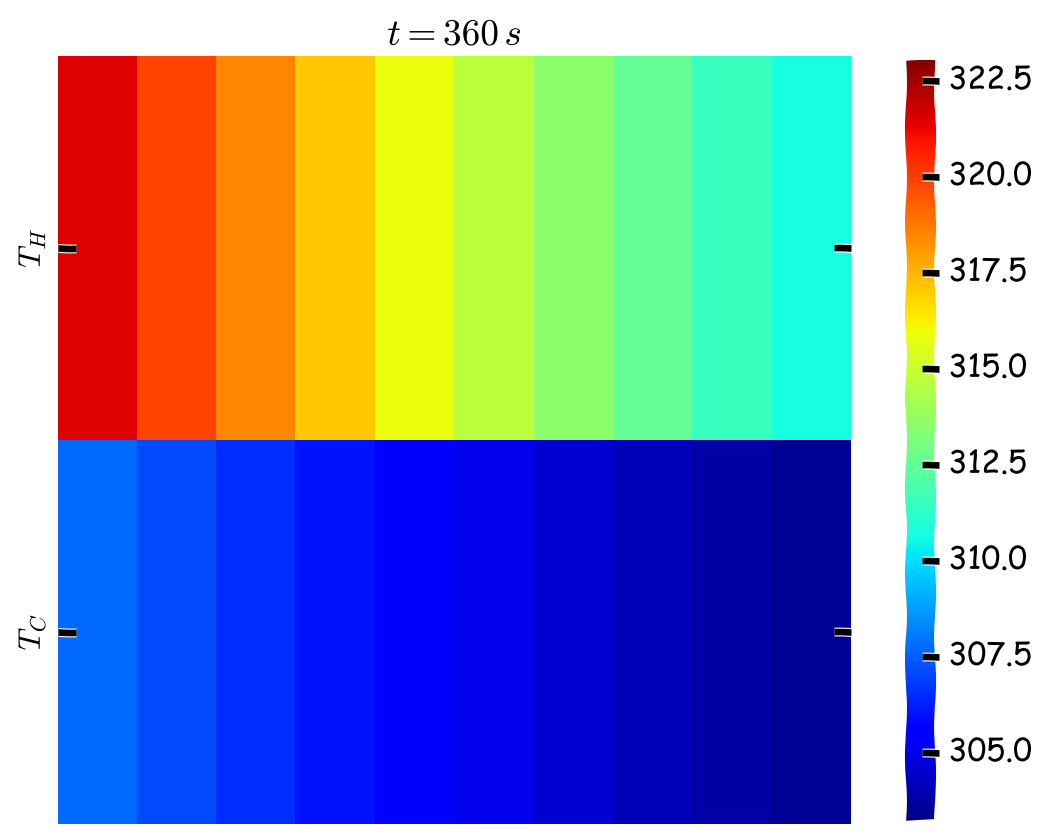

In [11]:
get_HeatMap_I(10, period1)

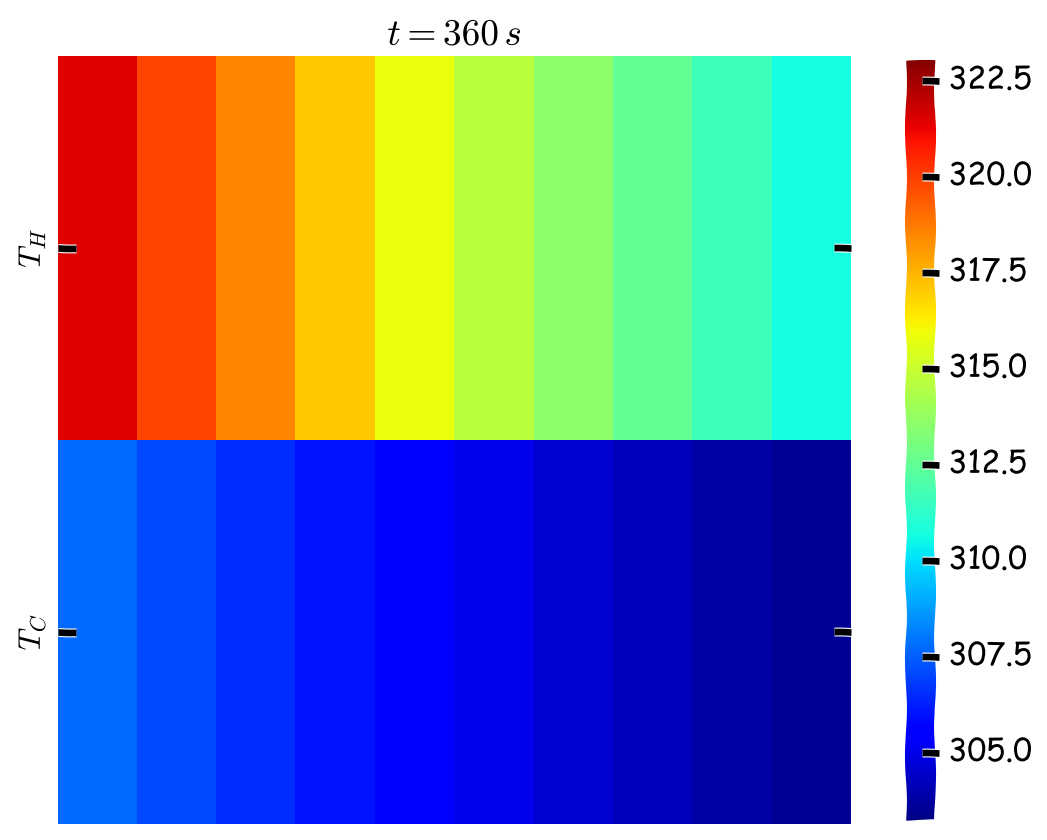

In [12]:
get_HeatMap_II(10, period2)

<center style="font-family:futura; font-size:150%;">100 grids</center>

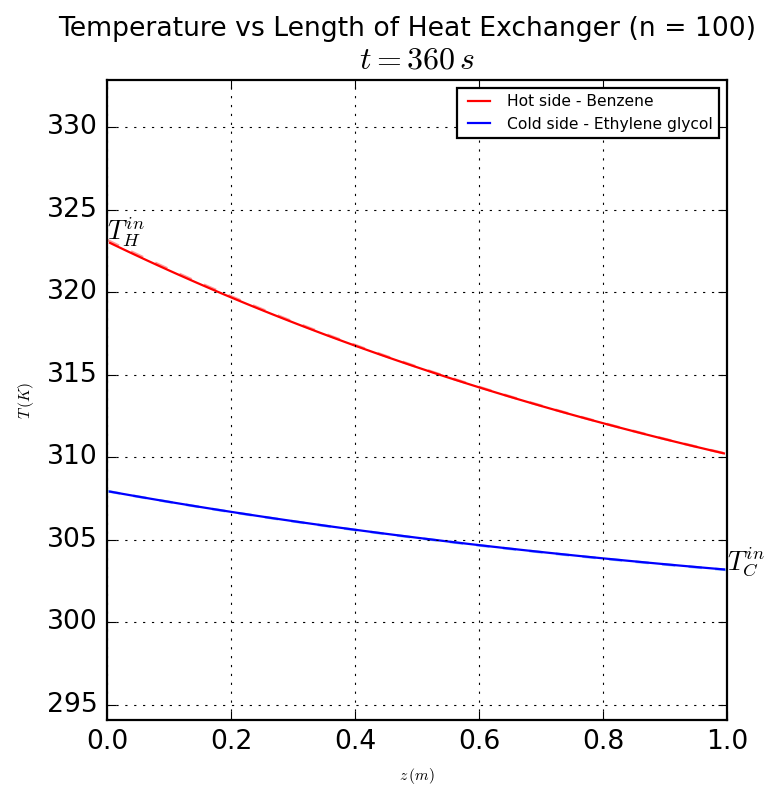

In [13]:
TYPEI_sol(100, period1)

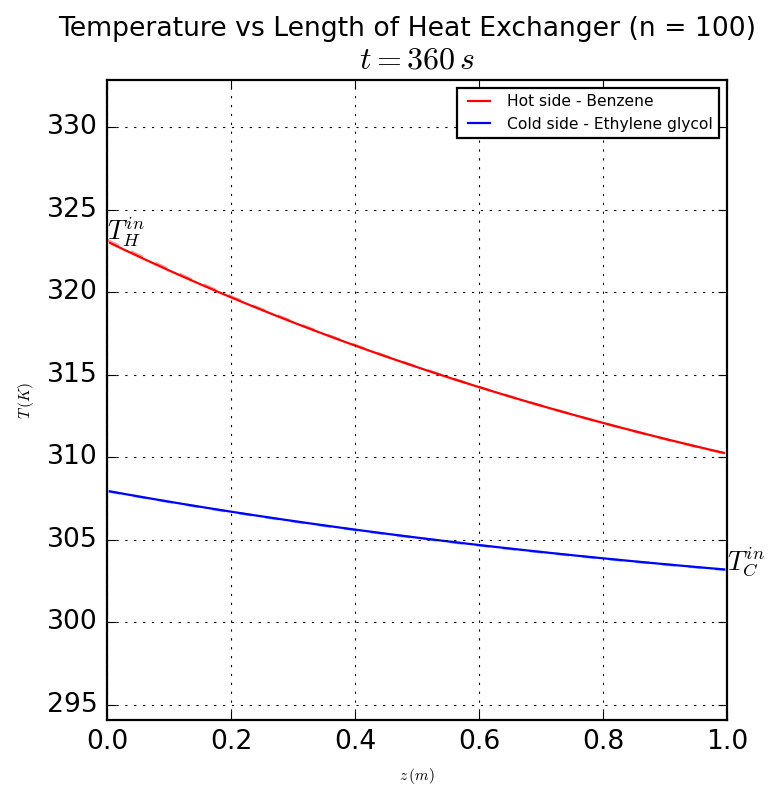

In [14]:
TYPEII_sol(100, period2) 

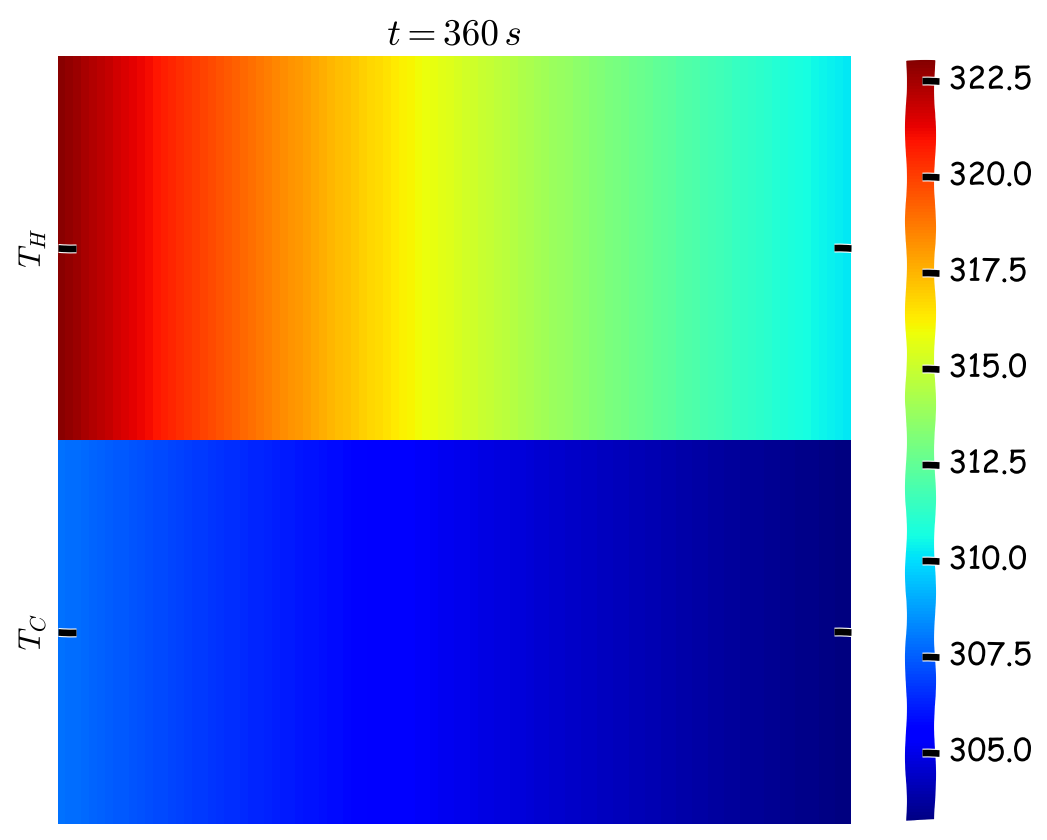

In [15]:
get_HeatMap_I(100, period1)

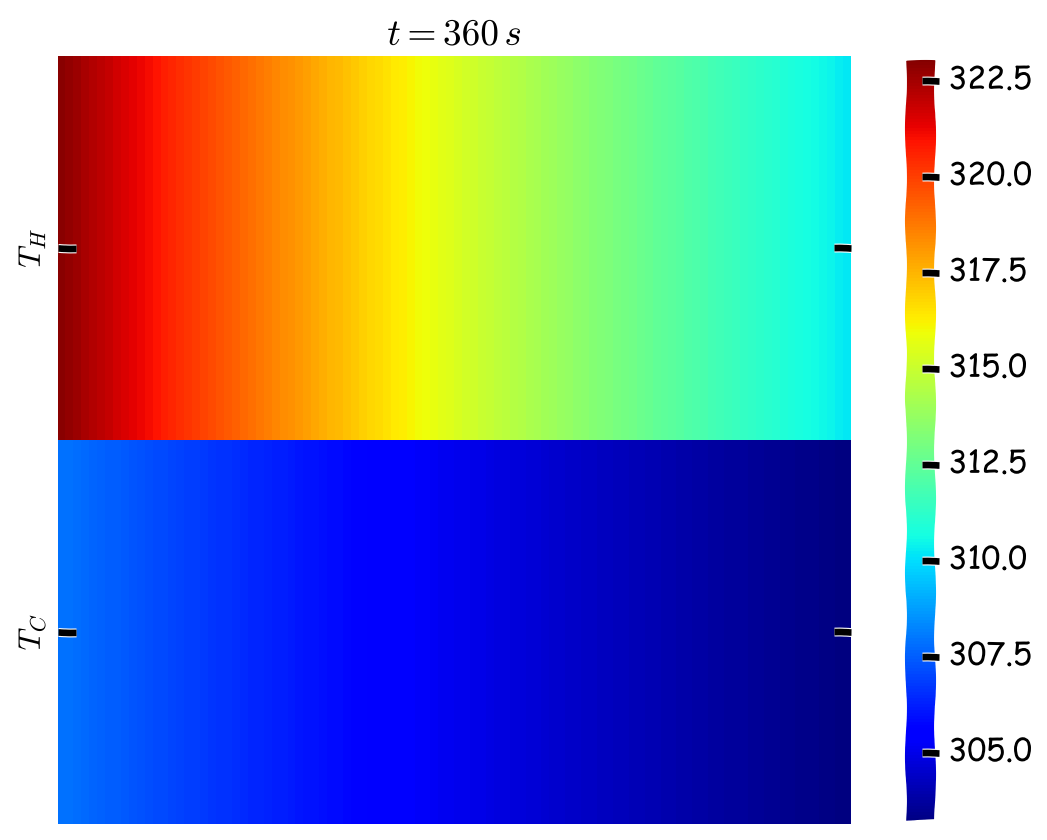

In [16]:
get_HeatMap_II(100, period2)

<center style="font-family:futura; font-size:150%;">Observations</center>

#### Influence of $n$
More the number of grids, more accurate is the solution but time taken to solve the system of equation increases.

#### Influence of initialization
When $\frac{T_H^{in} + T_C^{in}}{2}$ is the initial temperature vector ($T_{ini}$), the result is obtained faster than when $T_{ini} = T_C^{in}$ was the initial condition.

<center style="font-family:futura; font-size:150%;">What if $\rho = f(H)$ ?</center>

DIPPR105 Equation for calculation of liquid density:
$$\rho = \frac{A}{B^{1 + (1 - \frac{T}{C}) ^ D}}$$

In [17]:
def get_density_params(s):
    if s == 'Ethylene glycol':
        s = '1,2-Ethanediol'
    density_url = 'http://ddbonline.ddbst.de/DIPPR105DensityCalculation/DIPPR105CalculationCGI.exe?component=' + s
    density = pd.read_html(density_url)[6]
    density = density.drop(density.index[0:3]).drop('No.', axis=1)
    A = float(density['A'])
    B = float(density['B'])
    C = float(density['C'])
    D = float(density['D'])
    return [A, B, C, D]

[Ah, Bh, Ch, Dh] = get_density_params(compH)
[Ac, Bc, Cc, Dc] = get_density_params(compC)

# WDV = With Density Variation

class CounterCurrentHX_WDV:
    def __init__(self, n):
        self.U = 350.0  # W/m2-K
        self.P = np.pi * 0.1  # m2/m
        self.AcH = np.pi * 0.25 * 0.1 ** 2  # m2
        self.AcC = np.pi * 0.25 * 0.1 ** 2  # m2
        self.L = 1.0  # m
        
        self.mH = 0.05  # kg/s
        self.mC = 0.10  # kg/s
        
        self.T_Hin = 323.16  # K
        self.T_Cin = 303.16  # K
        
        self.n = n # Number of grid points
                
        self.Tini = np.ones(self.n * 2) * self.T_Cin
#         Tini[:self.n] = Tini[:self.n] * self.T_Hin
#         Tini[self.n:] = Tini[self.n:] * self.T_Cin

    def model(self, H, t): 
        H_hot = H[:self.n]
        H_cold = H[self.n:]

        T_hot = T_H(H_hot)
        T_cold = T_C(H_cold)
        
        H_Hin = H_H(self.T_Hin)
        H_Cin = H_C(self.T_Cin)
        
        dz = self.L / self.n
        
        rhoH = Ah / Bh ** (1 + (1 - T_hot / Ch) ** Dh) # kg/m3
        rhoC = Ac / Bc ** (1 + (1 - T_cold / Cc) ** Dc) # kg/m3
        
        rhoHin = Ah / Bh ** (1 + (1 - self.T_Hin / Ch) ** Dh)
        rhoCin = Ac / Bc ** (1 + (1 - self.T_Cin / Cc) ** Dc)
        
        dH_hotdt = np.zeros(self.n)
        dH_colddt = np.zeros(self.n)
        
        dH_hotdt[1:] = self.mH / (self.AcH * rhoH[0:-1] * dz) * H_hot[0:-1] - self.mH / (self.AcH * rhoH[1:] * dz) * H_hot[1:] - self.U * self.P / (self.AcH * rhoH[1:]) * (T_hot[1:] - T_cold[1:]) 
        dH_colddt[:-1] = self.mC / (self.AcC * rhoC[1:] * dz) * H_cold[1:] - self.mC / (self.AcC * rhoC[:-1] * dz) * H_cold[:-1] + self.U * self.P / (self.AcC * rhoC[:-1]) * (T_hot[:-1] - T_cold[:-1]) 
        
        dH_hotdt[0] = self.mH / (self.AcH * rhoHin * dz) * H_Hin - self.mH / (self.AcH * rhoHin * dz) * H_hot[0] - self.U * self.P / (self.AcH * rhoHin) * (T_hot[0] - T_cold[0]) 
        dH_colddt[-1] = self.mC / (self.AcC * rhoCin * dz) * H_Cin - self.mC / (self.AcC * rhoCin * dz) * H_cold[-1] + self.U * self.P / (self.AcC * rhoCin) * (T_hot[-1] - T_cold[-1]) 

        return list(dH_hotdt) + list(dH_colddt)

    def solve(self, t):
        H0 = np.zeros(self.n * 2)
        H0[:self.n] = H_H(self.Tini[:self.n])
        H0[self.n:] = H_C(self.Tini[self.n:])
        
        sol = scipy.integrate.odeint(self.model, H0, t)
        
        dz = self.L / self.n
        pos = [(i + 0.5) * dz for i in range(self.n)] 

        self.t = t
        self.pos = pos
        self.sol = sol

In [18]:
def TYPEI_sol_WDV(n, period):
    t = np.linspace(0, period, n)
    hx = CounterCurrentHX_WDV(n)
    hx.solve(t)
    
    bvp = CrossCurrentHX()
    bvp.solve()
    
    fig = plt.figure(facecolor='white', figsize=(5, 5))
    plt.suptitle("Temperature vs Length of Heat Exchanger (n = %d)" % n)
    plt.grid()
    plt.xlim(0, hx.L)
    plt.ylim(0.97 * hx.T_Cin, 1.03 * hx.T_Hin)
    plt.xlabel(r"$z\, (m)$", fontsize=7)
    plt.ylabel(r"$T\, (K)$", fontsize=7)
    plt.plot(bvp.dfsol.z, bvp.dfsol.T_H, color='#ff9999', linewidth=1.2, linestyle='--')
    plt.plot(bvp.dfsol.z, bvp.dfsol.T_C, color='#80b3ff', linewidth=1.2, linestyle='--')
    plt.annotate(r'$T_H^{in}$', xy=(0, hx.T_Hin))
    plt.annotate(r'$T_C^{in}$', xy=(hx.L, hx.T_Cin))
    
    line1 = plt.plot([], 'r', label='Hot side - %s' % compH)[0]
    line2 = plt.plot([], 'b', label='Cold side - %s' % compC)[0]
    plt.legend(loc='best', fontsize=7)
    
    def animated_plot(i):  
        i = int(i)
        plt.title(r"$t = %d\, s$" % hx.t[i])
        line1.set_data((hx.pos, T_H(hx.sol[i][:hx.n]))) 
        line2.set_data((hx.pos, T_C(hx.sol[i][hx.n:]))) 
        return line1, line2
     
    animation = FuncAnimation(fig, animated_plot, frames=n, interval=200);
    animation.save('animation_%d_%d_I_rho.gif' % (n, period), writer='ffmpeg')
    return Image(url='animation_%d_%d_I_rho.gif' % (n, period))

def TYPEII_sol_WDV(n, period):
    t = np.linspace(0, period, n)
    hx = CounterCurrentHX_WDV(n)
    hx.Tini = np.ones(n * 2) * (hx.T_Hin + hx.T_Cin) / 2
    hx.solve(t)
    
    bvp = CrossCurrentHX()
    bvp.solve()
    
    fig = plt.figure(facecolor='white', figsize=(5, 5))
    plt.suptitle("Temperature vs Length of Heat Exchanger (n = %d)" % n)
    plt.grid()
    plt.xlim(0, hx.L)
    plt.ylim(0.97 * hx.T_Cin, 1.03 * hx.T_Hin)
    plt.xlabel(r"$z\, (m)$", fontsize=7)
    plt.ylabel(r"$T\, (K)$", fontsize=7)
    plt.plot(bvp.dfsol.z, bvp.dfsol.T_H, color='#ff9999', linewidth=1.2, linestyle='--')
    plt.plot(bvp.dfsol.z, bvp.dfsol.T_C, color='#80b3ff', linewidth=1.2, linestyle='--')
    plt.annotate(r'$T_H^{in}$', xy=(0, hx.T_Hin))
    plt.annotate(r'$T_C^{in}$', xy=(hx.L, hx.T_Cin))
    
    line1 = plt.plot([], 'r', label='Hot side - %s' % compH)[0]
    line2 = plt.plot([], 'b', label='Cold side - %s' % compC)[0]
    plt.legend(loc='best', fontsize=7)
    
    def animated_plot(i):  
        i = int(i)
        plt.title(r"$t = %d\, s$" % hx.t[i])
        line1.set_data((hx.pos, T_H(hx.sol[i][:hx.n]))) 
        line2.set_data((hx.pos, T_C(hx.sol[i][hx.n:]))) 
        return line1, line2
     
    animation = FuncAnimation(fig, animated_plot, frames=n, interval=200);
    animation.save('animation_%d_%d_II_rho.gif' % (n, period), writer='ffmpeg')
    return Image(url='animation_%d_%d_II_rho.gif' % (n, period))

<p style="font-family:futura;">Initialization TYPE I</p>

```python
Tini = np.ones(n * 2) * T_Cin
```

<p style="font-family:futura;">Initialization TYPE II</p>

```python
Tini = np.ones(n * 2) * (T_Hin + T_Cin)/2
```

<center style="font-family:futura; font-size:150%;">10 grids</center>

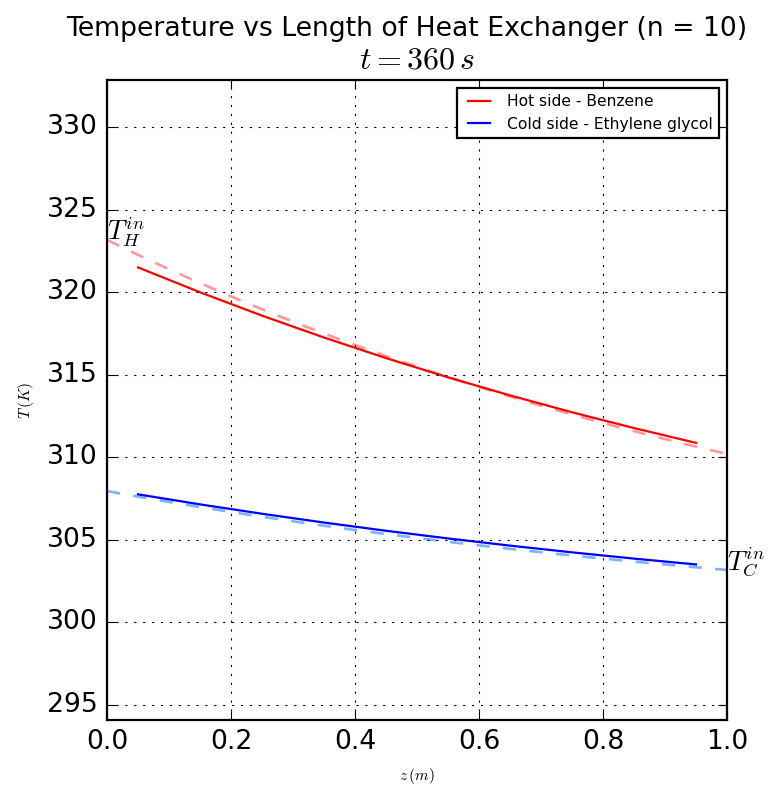

In [19]:
TYPEI_sol_WDV(10, period1)

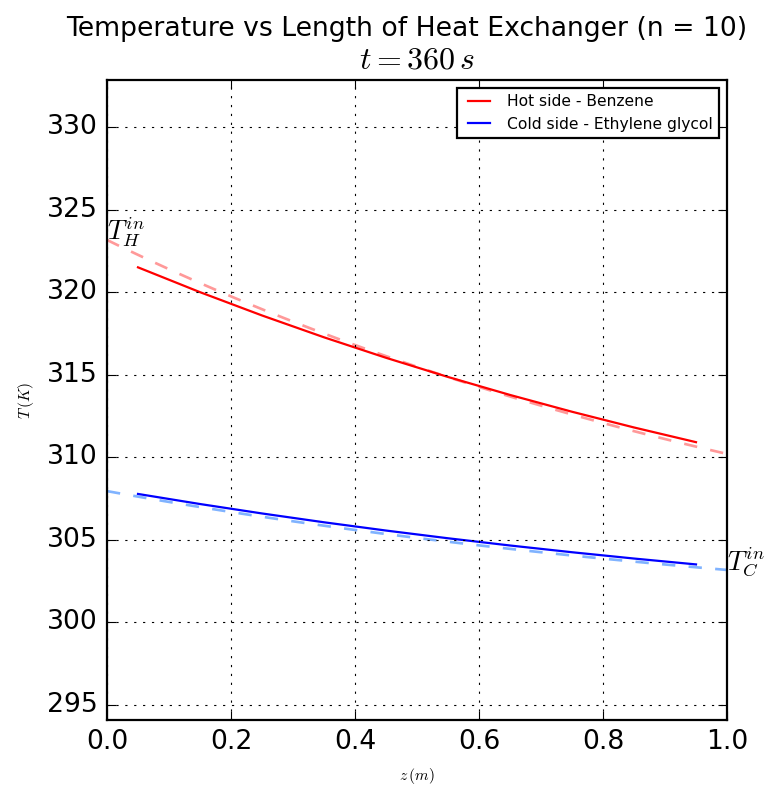

In [20]:
TYPEII_sol_WDV(10, period2) 

<center style="font-family:futura; font-size:150%;">100 grids</center>

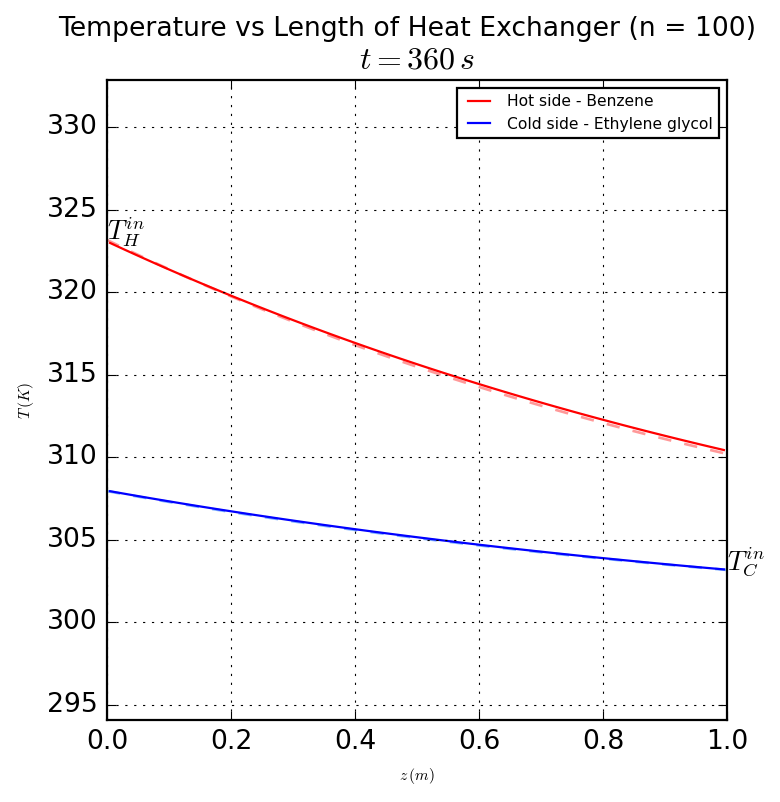

In [21]:
TYPEI_sol_WDV(100, period1)

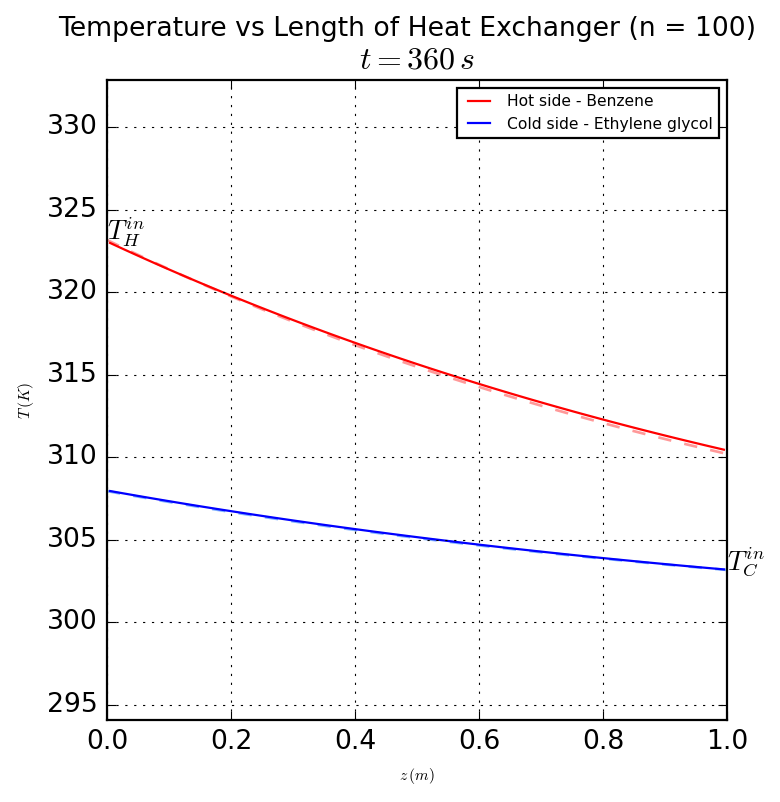

In [22]:
TYPEII_sol_WDV(100, period2) 

---
<p style="color:#737373; font-family:futura;">Sources: 

<ol style="color:#737373; font-family:futura;">
    <li> Perry, R. H., &amp; Green, D. W. (2008). Physical and Chemical Data. In Perry's chemical engineers' handbook (pp. 165-170). McGraw Hill
    </li>
    <li> <a href="http://ddbonline.ddbst.de/DIPPR105DensityCalculation/DIPPR105CalculationCGI.exe?component=Water">DDBST's site for density calculation by DIPPR105 equation</a>
    </li>
</ol> 

</p>